# RNNs

*You can watch a [video](https://youtu.be/4wuIOcD1LLI) of this lesson if you prefer.*

In the [last lesson](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/classification.ipynb), we learned how to use a neural network to perform classification.  This is one important piece of using a neural network to do NLP (natural language processing).

In this lesson, we'll learn another important piece - how to use neural networks to take in sequences of input and make predictions.  A sequence of input can be a sentence made up of words, or a series of weather observations.

Each element in a sequence has a position.  We can think of those positions as being steps in time.  Here is a sequence of temperatures:

In [1]:
import pandas as pd
import numpy as np

# Read in our data, and fill missing values
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
data = data.ffill()

# Display a sequence of temperatures
data["tmax"].head(10)

1970-01-01    60.0
1970-01-02    52.0
1970-01-03    52.0
1970-01-04    53.0
1970-01-05    52.0
1970-01-06    50.0
1970-01-07    52.0
1970-01-08    56.0
1970-01-09    54.0
1970-01-10    57.0
Name: tmax, dtype: float64

The sequence has 10 elements.  The first sequence element (at time step 0) is `60`.  The second sequence element (at time step 1) is `52`, and so on.

Let's say we want to predict the next element in the sequence (at time step `10`).  With a normal neural network, you have to treat each element in a sequence as a separate input feature, like this:

In [2]:
# Turn our sequence into a single row of data
data["tmax"].head(10).to_numpy()[np.newaxis,:]

array([[60., 52., 52., 53., 52., 50., 52., 56., 54., 57.]])

We could feed the above sequence as a single training example into a neural network to predict the next temperature.  But what if we don't know the length of the sequence beforehand?  For example, what if we wanted the neural network to predict the next word that came after a prompt?

We could have prompts with different lengths, like:

- `Write me a song`
- `Tell me a story about dinosaurs`
- `Add 1 and 2`

We want our network to be able to handle all of these inputs, even though they have different lengths.  One way to do this is to add extra zeros to the end of the sequence to make all of the sequences the same length.  Then our network will handle a fixed-sized input.

But this introduces the issue that the neural network will have to learn parameters for each position separately.  For example, if we're passing in two weather observations of different lengths:

In [148]:
data["tmax"].head(6).to_numpy()[np.newaxis,:]

array([[-0.72725587, -1.68779357, -1.68779357, -1.56772636, -1.68779357,
        -1.92792799]])

In [149]:
data["tmax"].tail(10).to_numpy()[np.newaxis,:]

array([[-0.24698703, -0.36705424, -0.48712145, -0.60718866, -0.72725587,
        -0.48712145,  0.11321461, -0.0068526 ,  0.47341624, -0.48712145]])

These temperatures are all related - the temperature today affects the temperature tomorrow.  But if we train a neural network to evaluate each sequence position separately, it won't be able to efficiently learn the relationship between one sequence position and the next.  The network will effectively have to re-learn this relationship between each pair of time steps.

Instead of the network being able to say "all time steps are related to the previous time step", it will have to say "time step `0` is related to time step `1`, time step `1` is related to time step `2`", and so on.  This is a lot less efficient.

RNNs are a kind of neural network that solve this problem by processing an entire sequence at once.  In this lesson, we'll learn how to build one in Python.

## RNN Architecture

RNNs work by sharing parameters (weights and biases) across steps in a sequence.  At a very high level, a recurrent neural network looks like this:

![Rolled RNN](images/rnn/rnn_rolled.svg)

What we see above is called a compact representation of an RNN.  We pass input (values from a single time step) into the bottom of an RNN.  It is then passed through the input step (I) and the hidden step (H) before getting to the output step (O) where you get a prediction for the next element in the sequence.

The arrow connecting H to itself is called recurrence.  It means that the H layers are connected to each other across sequence steps.  To see how this works, let's take a look at an expanded representation of an RNN:

![Unrolled RNN](images/rnn/rnn_unrolled.svg)

Each sequence element is labeled at the bottom with the time step of the element.  The first element in the sequence is `t0`, the second is `t1`, and so on.  You can see that each element is passed into the input step, then to the hidden step.  But the output of the hidden step is passed both to the output, and to the next hidden step.

This means that at each step, an RNN knows about the inputs at previous steps.  The "memory" of the network is stored in the hidden step (H), and represented as an internal matrix of values.  This matrix is updated at each time step with new information about the sequence.

## RNN Operations

It can help to look at the exact operations that happen at each step in an RNN:

![Unrolled RNN](images/rnn/rnn_operations.svg)

An RNN has 3 steps:

- Input - take in a sequence item, and multiply it by the input weight
- Hidden - Take the previous hidden state, and multiply it by the hidden weight.  Add in the input, then apply a nonlinear activation function.
- Output weight - Take the hidden state, and multiply by the output weight.

We also add in bias terms at the hidden and output steps, but the biases are left off the diagram to make it easier to read.

The trickiest part of an RNN is the hidden step.  It's this step that gives an RNN its power, by enabling it to have memory.  The hidden state of the RNN stores information about previous sequence elements.  The hidden weights enable the RNN to remember or forget certain information about past sequence elements.

This way, the RNN can have knowledge of past elements in the sequence without having separate parameters for each sequence item.  This is called parameter sharing - the RNN shares the same set of input, hidden, and output weights for every sequence element.

This enables the RNN to be used for sequences of any length - we don't need a fixed size input sequence length.

## Forward Pass

Let's go through an example to see how this works.  We'll initialize each weight matrix, then do a sample forward pass with 3 sequence elements:

In [5]:
# Set a random seed so the random numbers are the same every time
np.random.seed(0)
# Take the input number and turn it into 2 features
i_weight = np.random.rand(1,2)
# Hidden to hidden weight connection - 2 features to 2 features
h_weight = np.random.rand(2,2)
# Output weight connection - turn 2 features into one prediction
o_weight = np.random.rand(2,1)

# Get 3 temperature values from our data
temps = data["tmax"].tail(3).to_numpy()
temps

array([66., 70., 62.])

Above, we initialized our network parameters.  We used the numpy `random.rand` function to randomly create parameter matrices of a certain shape.  This network will take in a single input feature, turn it into `2` hidden features, and output one prediction.

We can then setup our input to the forward pass.  We'll reshape each input value into a `1x1` matrix to make multiplication more convenient:

In [6]:
# Assign the sequence input at each time step to a different variable.
# x0 means input at time step 0
# Ensure that each element is a 1x1 matrix, so we can multiply it
x0 = temps[0].reshape(1,1)
x1 = temps[1].reshape(1,1)
x2 = temps[2].reshape(1,1)

Now we can feed the element at time step 0 into our network:

In [7]:
# Calculate xi at time step 0
xi_0 = x0 @ i_weight

# There is no previous time step, so there is no hidden state
# apply relu over the input to get the hidden state for time step 0 xh_0
xh_0 = np.maximum(0, xi_0)

# Get the output at time step 0 xo_0
xo_0 = xh_0 @ o_weight

xo_0

array([[57.94406231]])

`xo_0` is our prediction for the next step in the sequence.

We can then move the network forward to time step `1`:

In [8]:
# We feed the input in the same way as the previous time step
xi_1 = x1 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_0 by the hidden weights
xh = xh_0 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 1
xh_1 = np.maximum(0, xh + xi_1)

# We again find the output by multiplying xh_1 by the output weight
xo_1 = xh_1 @ o_weight

xo_1

array([[124.54916092]])

`xo_1` is our prediction for the next sequence element.  Now we can do the same for our final time step, 2:

In [9]:
# We feed the input in the same way as the previous time step
xi_2 = x2 @ i_weight

# This time, we do have a previous time step, so we calculate xh
# This is multiplying the previous hidden state xh_1 by the hidden weights
xh = xh_1 @ h_weight

# We add the previous hidden state (times h_weight) to the input at time step 2
xh_2 = np.maximum(0, xh + xi_2)

# We again find the output by multiplying xh_1 by the output weight
xo_2 = xh_2 @ o_weight

xo_2

array([[190.94853131]])

We've now passed through 3 forward steps of our RNN!  The output `x0` at each time step is the prediction for the next element in the sequence.

The hidden state of the RNN allows the network to have information about all past sequence elements.  So when we're processing the sequence item at time step 2, the hidden state of the RNN stores information about the sequence elements at time step `0` and `1`.

## Nonlinearity

You may have noticed that the output values increased in each time step of our RNN.  That's because the hidden states kept getting larger and larger.  Unlike the sigmoid or softmax activation functions, relu doesn't change the scale of the inputs at all (it just sets some to 0).  This means that some values get repeatedly multiplied and grow larger and larger.

We can see this below:

In [10]:
xh_0

array([[36.22169126, 47.20249818]])

In [11]:
xh_2

array([[124.88411227, 152.84252918]])

We can see that our hidden state at time step 2 is much larger than the initial hidden state.

To fix this, we usually use the $\tanh$ activation function for RNNs.  The equation for $\tanh$ is:

$$\tanh = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$$

As x gets large, $e^{x}$ gets very big, and $e^{-x}$ gets very small.  This pushes the output of $\tanh$ towards `1`.  When x gets very small (negative), $e^{-x}$ gets very large, and $e^{x}$ gets very small.  This results in `-1`.

We can graph the $tanh$ function to see how this works:

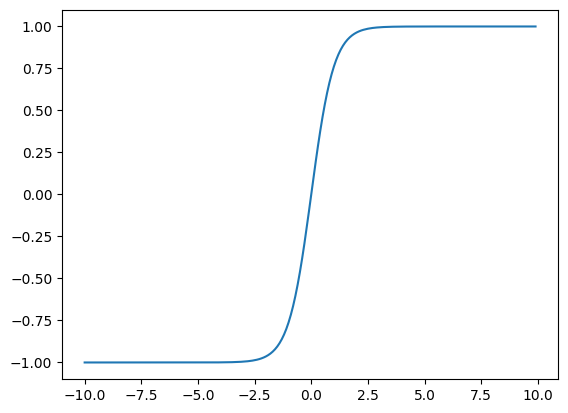

In [12]:
import matplotlib.pyplot as plt
# Define some temperature values
temps = np.arange(-10, 10, .1)

# Plot the tanh of the values
plt.plot(temps, np.tanh(temps))

$\tanh$ outputs values between `-1` and `1`.  It also has a very steep slope before and after `0` on the x-axis.  The tanh activation function is better for our purposes than sigmoid because it enables us to have negative values.  This enables the gradient to be steeper, which aids in gradient descent.

Let's take a look at the derivative of tanh using sympy:

In [13]:
from sympy import diff, symbols, exp

x = symbols("x")
sympy_tanh = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
diff(sympy_tanh, x)

(-exp(x) + exp(-x))*(exp(x) - exp(-x))/(exp(x) + exp(-x))**2 + 1

Sympy doesn't quite simplify the derivative all the way.  Like the derivatives of the sigmoid and softmax functions, we can express the derivative of $\tanh{x}$ in terms of the output - $1 - \tanh^2{x}$.  We can then graph this derivative:

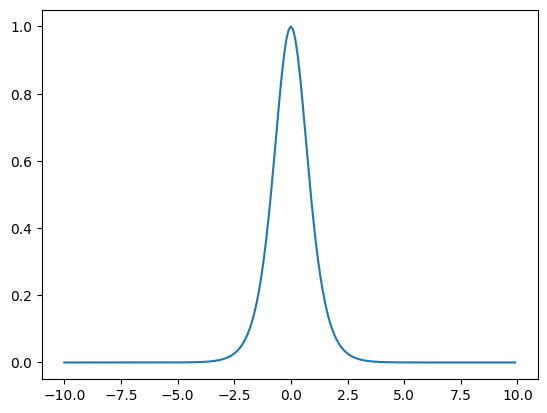

In [14]:
plt.plot(temps, 1 - np.tanh(temps) ** 2)

As you can see, the derivative has a steep slope, making it ideal as an activation function - this will enable gradient descent to descend effectively.  We can now use $\tanh$ instead of relu in our network.

## Full Forward Pass

We now know enough to put together a complete RNN forward pass.  We'll first initialize our weights and biases.  We'll add in bias terms in the hidden and output steps.

We'll also scale the weights and biases to work properly with the $\tanh$ nonlinearity.  We'll make our input and hidden weights small, so $\tanh$ doesn't squash all the values to `1` or `-1`.  We'll make the output weight large, since the output of the hidden step will be small (between `1` and `-1`).  Of course, in a full RNN, the network would eventually learn the correct parameters.  But initializing weights and biases to the correct ranges helps with gradient descent.

In [15]:
np.random.seed(0)

# Define our weights and biases
# Scale them down so values get through the tanh nonlinearity
i_weight = np.random.rand(1,5) / 5 - .1
h_weight = np.random.rand(5,5) / 5 - .1
h_bias = np.random.rand(1,5) / 5 - .1

# Tanh pushes values to between -1 and 1, so scale up the output weights
o_weight = np.random.rand(5,1) * 50
o_bias = np.random.rand(1,1)

Then we can write the forward pass as a for loop.  This loop will process sequence elements one by one.  We'll store the output prediction and the hidden state:

In [150]:
# An array to store the output predictions
outputs = np.zeros(3)
# An array to store hidden states for use in backpropagation
hiddens = np.zeros((3, 5))

# This will store the previous hidden state, since we'll need it to calculate the current hidden step
prev_hidden = None
sequence = data["tmax"].tail(3).to_numpy()

for i in range(3):
    # Get the input sequence at the given position
    x = sequence[i].reshape(1,1)

    # Multiply input by input weight
    xi = x @ i_weight
    if prev_hidden is not None:
        # Add previous hidden to input
        xh = xi + prev_hidden @ h_weight + h_bias
    else:
        xh = xi

    # Apply our activation function
    xh = np.tanh(xh)
    prev_hidden = xh
    hiddens[i,] = xh

    # Multiply by the output weight
    xo = xh @ o_weight + o_bias
    outputs[i] = xo

Afterwards, we can take a look at our outputs and hidden states.  As we can see, the hidden states don't increase constantly anymore:

In [17]:
outputs

array([74.31470595, 80.66149404, 77.67852446])

In [151]:
hiddens

array([[ 2.74338471e-04, -2.89009929e-04, -3.20562379e-05,
         3.67012717e-04,  2.85825121e-04],
       [-6.63092480e-02,  7.42736825e-02, -6.91914532e-03,
        -1.20488975e-02, -1.15884296e-01],
       [-2.94826242e-02,  4.33377272e-02, -2.63269775e-02,
         3.78706198e-02, -7.86427108e-02]])

## Calculating loss

After we do our forward pass, we can calculate the gradient with respect to the network outputs using `mse_grad`:

In [19]:
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

def mse_grad(actual, predicted):
    return (predicted - actual)

In [152]:
# Actual next day temperatures
actuals = np.array([70, 62, 65])

loss_grad = mse_grad(actuals, outputs)
loss_grad

array([-69.61482716, -66.14775128, -65.93075892])

## Backward Pass

Now that we've written a forward pass, let's think about the backward pass to update our model parameters.  The main complication in the backward pass is that parameters impact both the current output and future outputs.

Let's visualize this, starting with the last sequence item:

![last hidden](images/rnn/gradient_last.svg)

As you can see above, the last hidden step is only used by the output of the last time step.  But this is different for other hidden steps:

![prev hidden](images/rnn/gradient_inside.svg)

The hidden step at time step 2 is connected to both the output and the next hidden state.  So it affects not just the current output, but all subsequent outputs, too.

We have to consider this fact when we do backpropagation - some parameters will impact multiple outputs.  This means that they need to get gradients from multiple outputs to be properly adjusted.

We'll have to send the gradient with respect to each hidden step backwards to the previous sequence position.  This is called backpropagation through time, and it's how we train the parameters of an RNN.

Here are the operations we will follow to do a backward pass.  They're essentially a reverse of the forward pass:

![rnn backward](images/rnn/rnn_operations_bw.svg)


Let's implement the backward pass one by one for each sequence element.

We start out by creating variables to store the gradients with respect to each parameter.  We do this because we want to sum the gradients across time positions before making updates with gradient descent:

In [157]:
# These will keep a running total of the gradients
o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

Then, we can run backpropagation for the last sequence element (we start at the end).  In this case, there is no next hidden state, so we only need to worry about the gradient wrt the output at this position:

In [158]:
# Get the loss wrt the output at the current time step
l2_grad = loss_grad[2].reshape(1,1)

# Add to the output weight gradient
# Multiply the output of the hidden step (hiddens[2]) transposed by the l2 grad
# np.newaxis creates a new size 1 axis, effectively transposing the hiddens
o_weight_grad += hiddens[2][:,np.newaxis] @ l2_grad
# Add to the bias gradient.  Similar to a dense neural network, this is just the mean of the l2_grad.
o_bias_grad += np.mean(l2_grad)

# Find the gradient wrt the hidden step output
h2_grad = l2_grad @ o_weight.T

# Derivative of the tanh function
tanh_deriv = 1 - hiddens[2,:][np.newaxis,:] ** 2
# Multiply each position in the h_grad by the tanh derivative - this "undoes" the tanh in the forward pass
h2_grad = np.multiply(h2_grad, tanh_deriv)

# Now, find how much we need to update the hidden weights.
# We take the input to the hidden step (the output of the previous hidden step in the forward pass) @ h2_grad
h_weight_grad += hiddens[1,:][:,np.newaxis] @ h2_grad
h_bias_grad += np.mean(h2_grad)

# This multiples the sequence value at time step 2 by the gradient
# We don't need the .T here, but I left it here in case you have a larger input size
i_weight_grad += sequence[2].reshape(1,1).T @ h2_grad

A lot of the above step is very similar to backpropagation in a dense neural network.  The main difference comes in the next sequence position (1) where we need to consider multiple gradients at the hidden step:

In [159]:
l1_grad = loss_grad[1].reshape(1,1)

o_weight_grad += hiddens[1][:,np.newaxis] @ l1_grad
o_bias_grad += np.mean(l1_grad)

h1_grad = l1_grad @ o_weight.T

# We do have a next sequence position (2), so we need to include that gradient
# We multiply the h2 gradient by the weight to pull it back to the current sequence position
h1_grad += h2_grad @ h_weight.T

# The rest of the operation is the same
tanh_deriv = 1 - hiddens[1,:][np.newaxis,:] ** 2
h1_grad = np.multiply(h1_grad, tanh_deriv)

h_weight_grad += hiddens[1,:][:,np.newaxis] @ h1_grad
h_bias_grad += np.mean(h1_grad)

i_weight_grad += sequence[1].reshape(1,1).T @ h1_grad

Now, we can do the final sequence position, 0.  The main difference here is that we don't update the hidden gradient, since there is no previous sequence position that gave us hidden state input in the forward pass:

In [160]:
l0_grad = loss_grad[0].reshape(1,1)

o_weight_grad += hiddens[0][:,np.newaxis] @ l0_grad
o_bias_grad += np.mean(l0_grad)

h0_grad = l0_grad @ o_weight.T

h0_grad += h1_grad @ h_weight.T

tanh_deriv = 1 - hiddens[0,:][np.newaxis,:] ** 2
h0_grad = np.multiply(h0_grad, tanh_deriv)

# We don't update the hidden weight, since there was no previous hidden state
# We can update the hidden bias if you want

i_weight_grad += sequence[0].reshape(1,1).T @ h0_grad

We can now look at our gradient updates:

In [161]:
i_weight_grad

array([[-154.9774425 ,  -61.87971495,  -11.63213862,  -81.30882966,
          17.37148576]])

We've now completed backpropagation across 3 time steps!  We'll see how to make the gradient updates in the next section.

## Full Backward Pass

Similar to a forward pass, we can implement the full backward pass as a loop.  Here it is:

In [155]:
next_hidden = None

o_weight_grad, o_bias_grad, h_weight_grad, h_bias_grad, i_weight_grad = [0] * 5

for i in range(2, -1, -1):
    l_grad = loss_grad[i].reshape(1,1)

    o_weight_grad += hiddens[i][:,np.newaxis] @ l_grad
    o_bias_grad += np.mean(l_grad)

    o_grad = l_grad @ o_weight.T

    # Only add in the hidden gradient if a next sequence exists
    if next_hidden is not None:
        h_grad = o_grad + next_hidden @ h_weight.T
    else:
        h_grad = o_grad

    tanh_deriv = 1 - hiddens[i,:][np.newaxis,:] ** 2
    h_grad = np.multiply(h_grad, tanh_deriv)

    next_hidden = h_grad

    # Don't update the hidden weights for the first sequence position
    if i > 0:
        h_weight_grad += hiddens[i-1,:][:,np.newaxis] @ h_grad
        h_bias_grad += np.mean(h_grad)

    i_weight_grad += sequence[i].reshape(1,1).T @ h_grad

We can then use gradient descent to make parameter updates:

In [25]:
lr = 1e-6
# We'll divide the learning rate by the sequence length, since we were adding together the gradients
# This makes training the model more stable
lr = lr / 3

i_weight -= i_weight_grad * lr
h_weight -= h_weight_grad * lr
h_bias -= h_bias_grad * lr
o_weight -= o_weight_grad * lr
o_bias -= o_bias_grad * lr

## Full Implementation

We now know enough to do a full implementation of a complete network.  This code will mostly be the same as the forward and backward passes we already implemented.

We'll first load in and scale our data:

In [26]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

Then we can initialize our weights and biases.  We'll scale our parameters so they are relatively small.  This helps the network descend better:

In [27]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

Then we'll write a forward pass:

In [28]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

And a backward pass:

In [29]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

We can end by setting up a training loop and measuring error:

In [162]:
epochs = 250
lr = 1e-5

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")

Epoch: 0 train loss 3122.594400144508 valid loss 2171.3186862102025
Epoch: 50 train loss 30.593193275313595 valid loss 30.568271740103427
Epoch: 100 train loss 25.263986813543738 valid loss 24.435517510355645
Epoch: 150 train loss 22.9567624295313 valid loss 22.177010971976852
Epoch: 200 train loss 22.306774327704215 valid loss 21.557992202834164


As we can see above, the network reduces training and validation loss over successive epochs.  It will perform similarly to the RNN implementation in Pytorch, but it will descend more slowly.

## Wrap-up

We learned a lot in this lesson! You should now have a good idea of how to train a recurrent neural network.  Don't worry if you don't get all of the concepts immediately.  RNNs are tricky, and take multiple readings to really understand.

In the next lesson, we'll learn about how we can reduce test and validation error with regularization.